In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

In [13]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [14]:
# Get in dataset
data_features_test = pd.read_csv("datasets/energy-informatics-2020/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :21]
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')


train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(9000).batch(50))
test_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[9000:]).shuffle(999).batch(50))

def _preprocess(sample):
  return sample, sample


train_dataset = (train_dataset
                 .map(_preprocess))

train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name=None))>

In [15]:
input_shape = (21, 1)
encoded_size = 16
base_depth = 32

In [16]:
# loc = mu, scale = sigma
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1), reinterpreted_batch_ndims=1)

In [17]:

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    # tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv1D(base_depth, 1, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1D(base_depth, 1, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1D(2 * base_depth, 1, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1D(2 * base_depth, 1, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1D(4 * encoded_size, 1, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])
     

In [18]:

# should probably move away from Bernoulli
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=(encoded_size,)),
    tfkl.Reshape([1, encoded_size]),
    tfkl.Conv1DTranspose(2 * base_depth, 1, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv1DTranspose(2 * base_depth, 1, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1DTranspose(2 * base_depth, 1, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1DTranspose(base_depth, 1, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1DTranspose(base_depth, 1, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1DTranspose(base_depth, 1, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv1D(filters=1, kernel_size=1, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape),
])
     


In [19]:

vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [20]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

_ = vae.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
180/180 [==============================] - 5s 7ms/step - loss: 0.7037 - val_loss: 0.1834
Epoch 2/15
180/180 [==============================] - 0s 2ms/step - loss: -22.9018 - val_loss: 0.2052
Epoch 3/15
180/180 [==============================] - 0s 2ms/step - loss: -32.6975 - val_loss: 0.0707
Epoch 4/15
180/180 [==============================] - 0s 2ms/step - loss: -33.8704 - val_loss: 0.0856
Epoch 5/15
180/180 [==============================] - 0s 2ms/step - loss: -34.5868 - val_loss: 0.0616
Epoch 6/15
180/180 [==============================] - 0s 2ms/step - loss: -33.8690 - val_loss: 0.0396
Epoch 7/15
180/180 [==============================] - 0s 2ms/step - loss: -37.0458 - val_loss: 0.0953
Epoch 8/15
180/180 [==============================] - 0s 2ms/step - loss: -36.0810 - val_loss: 0.0106
Epoch 9/15
180/180 [==============================] - 0s 2ms/step - loss: -32.6987 - val_loss: 0.0373
Epoch 10/15
180/180 [==============================] - 0s 2ms/step - loss: -36.7626 

In [21]:
z = prior.sample(50000)
xtilde = decoder(z)

/tmp/ipykernel_141750/712925786.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


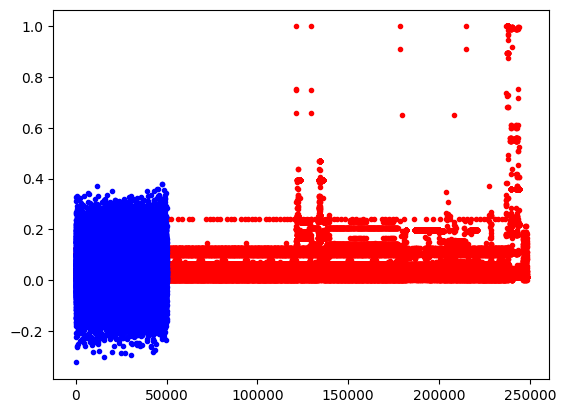

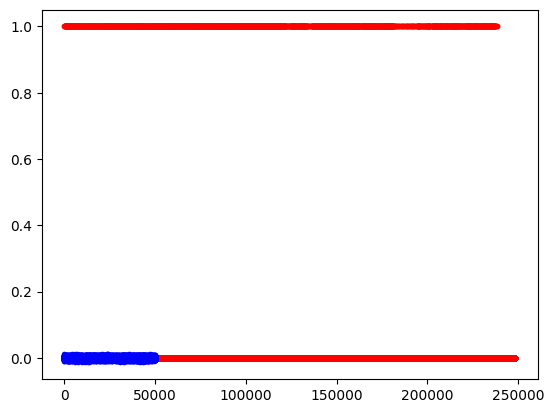

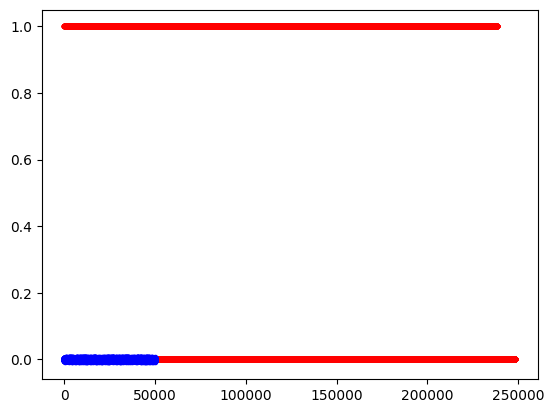

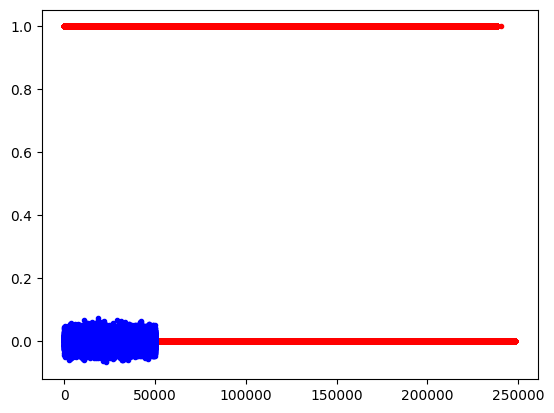

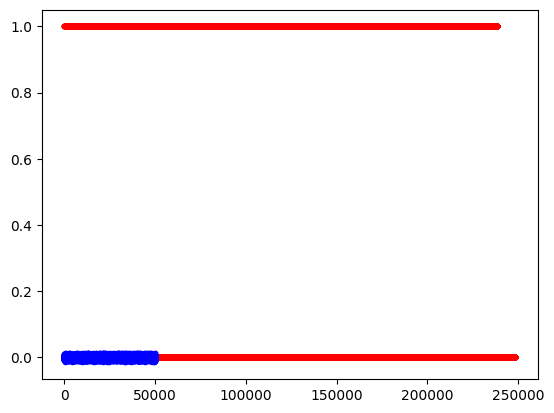

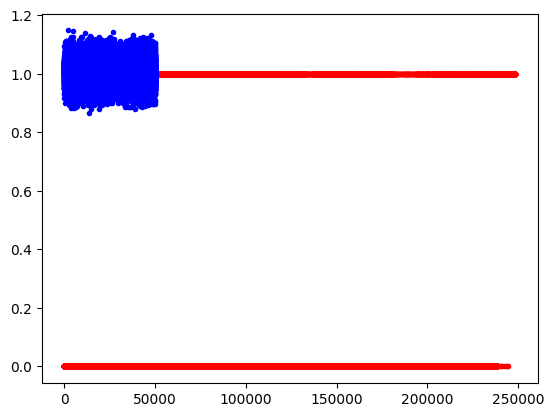

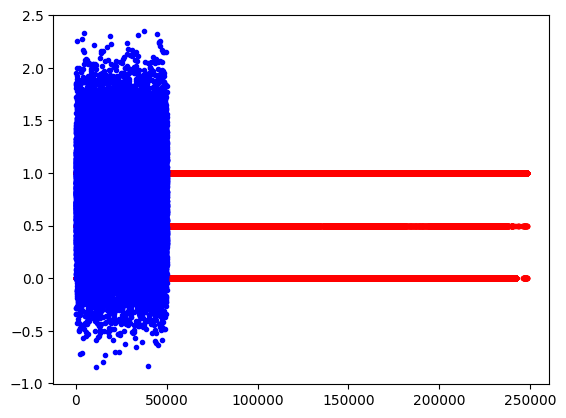

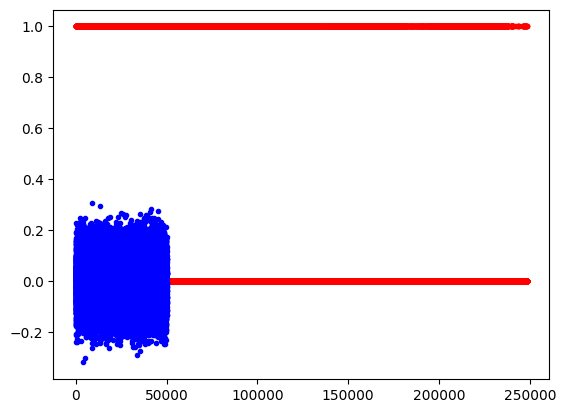

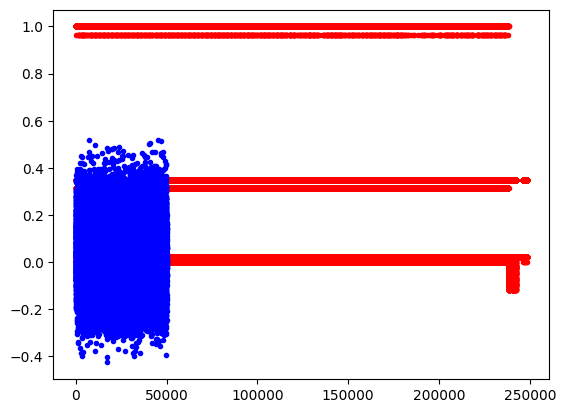

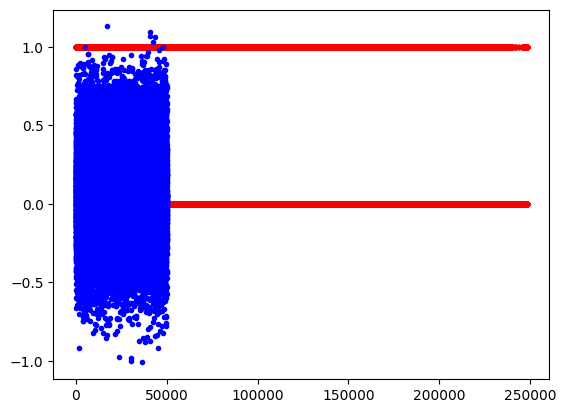

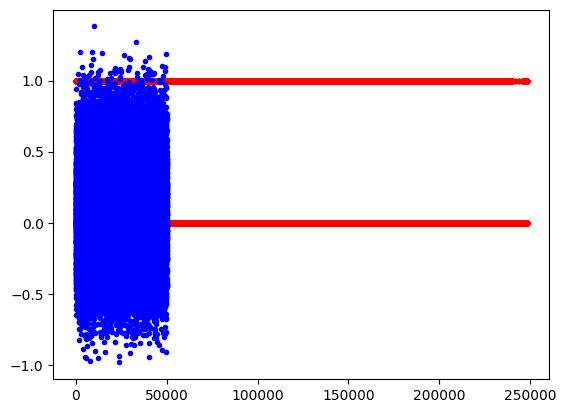

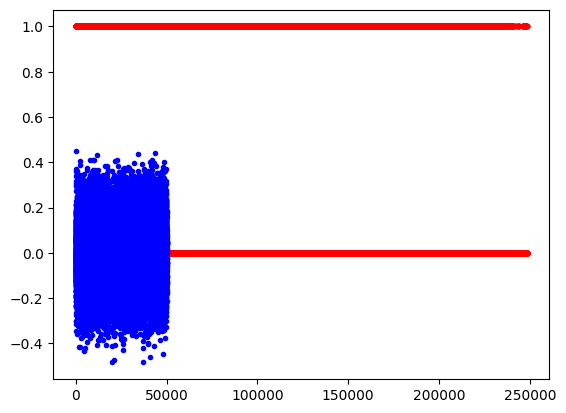

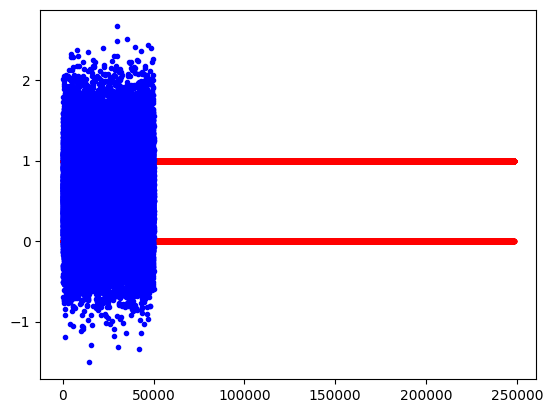

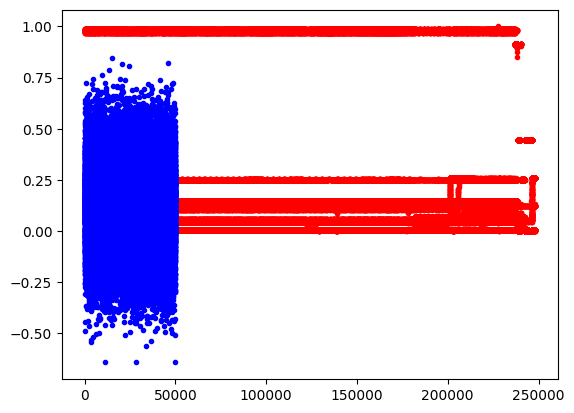

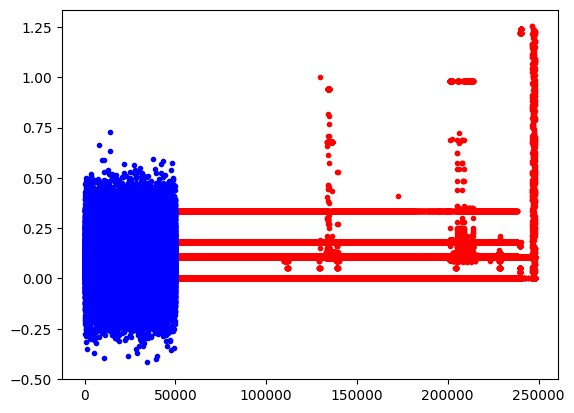

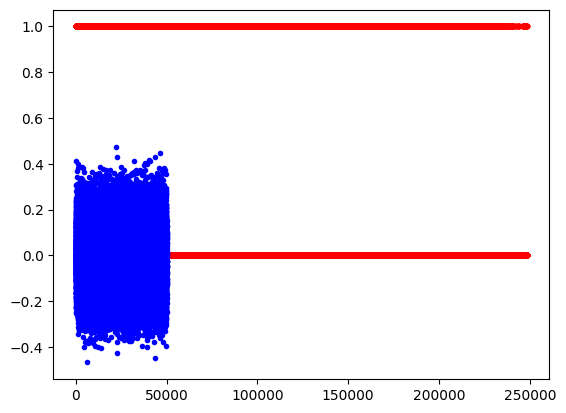

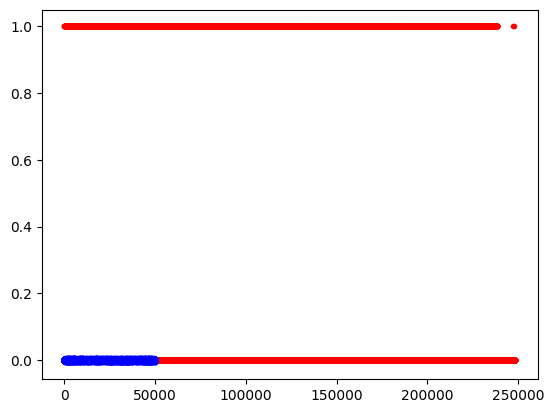

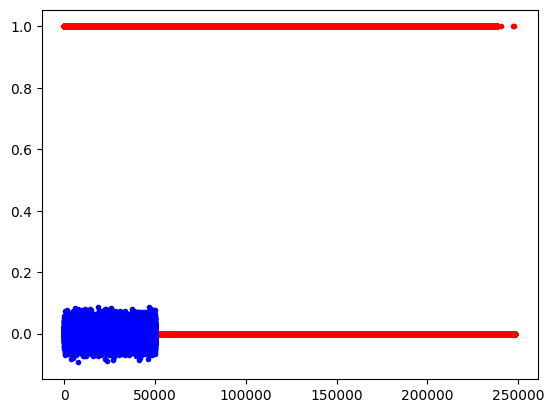

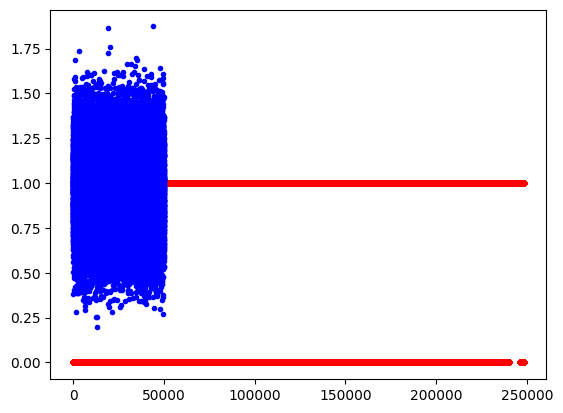

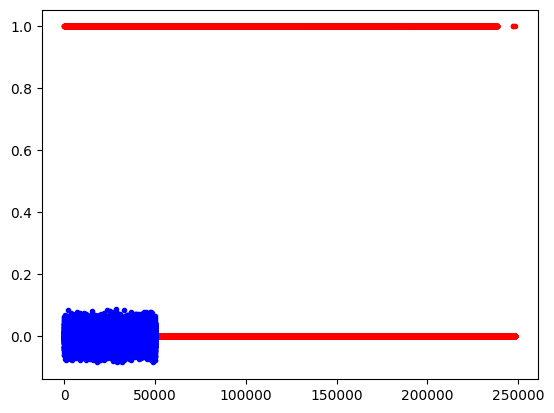

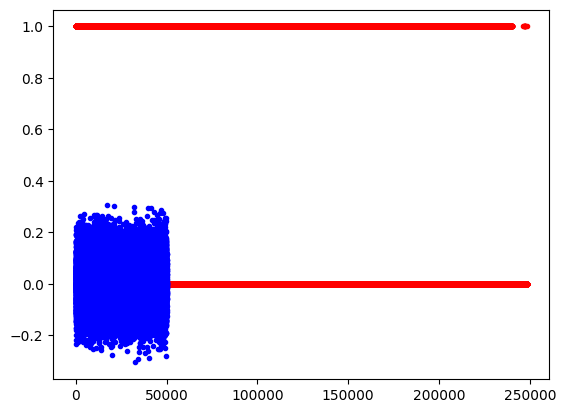

In [22]:
data_labels = [name for name in data_features_test.columns]

for i in range(21):
    feature = data_labels[i]
    plt.figure(i)
    plt.plot(data_features_test[feature], 'r.')
    plt.plot(xtilde[:,i], '.b')